# Apreçamento de opções com IA no Python

O aprendizado de máquina (ML) é visto como parte da inteligência artificial. Algoritmos de ML constroem um modelo com base em dados de treinamento para fazer previsões ou decisões sem serem explicitamente programados para fazê-lo. Neste exercício, usamos o Python para aplicar modelos de ML conhecidos como random forests e neural networks a uma aplicação simples na precificação de opções: o treinamento dos modelos para aprender a precificar opções de compra sem conhecimento prévio dos fundamentos teóricos da famosa equação de precificação de opções de Black e Scholes (1973).

## Dados

Os dados utilizados correspondem aos contratos de opções da empresa VALE durante o ano de 2023. Esses contratos são classificados como opções de compra ("Call options") e incluem uma variedade de informações essenciais para o cálculo do preço por meio da equação de Black-Scholes, explicada abaixo.



## Carregamento de Bibliotecas

In [ ]:
import pandas as pd
import numpy as np

from plotnine import *
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Apreçamento de ações

Em sua forma mais básica, opções de compra dão ao proprietário o direito, mas não a obrigação, de comprar uma ação específica (o ativo subjacente) a um preço específico (o preço de exercício $K$) em uma data específica (a data de exercício $T$). O preço de Black-Scholes (Black e Scholes 1973) de uma opção de compra para um ativo subjacente que não paga dividendos é dado por

\begin{aligned}
  C(S, T) &= \Phi(d_1)S - \Phi(d_2)Ke^{-r T} \\
     d_1 &= \frac{1}{\sigma\sqrt{T}}\left(\ln\left(\frac{S}{K}\right) + \left(r_f + \frac{\sigma^2}{2}\right)T\right) \\
     d_2 &= d_1 - \sigma\sqrt{T}
\end{aligned}

onde $C(S,t)$ é o preço da opção como função do preço da ação subjacente hoje, $S$, com tempo até o vencimento, $T$, $r$ é a taxa de juros livre de risco e $\sigma$ é a volatilidade do retorno da ação subjacente. $\Phi$ é a função de distribuição cumulativa de uma variável aleatória normal padrão.

A equação de Black-Scholes fornece uma maneira de calcular o preço livre de arbitragem de uma opção de compra uma vez que os parâmetros $S$, $T$ e $r$ são especificados (argumentavelmente, em um contexto realista, todos os parâmetros são fáceis de especificar, exceto $\sigma$, que deve ser estimado).



In [ ]:
# Carrega dados de opções da VALE
vale_options = (
                pd.read_csv('https://aluno.analisemacro.com.br/download/59143/?tmstv=1710246719', sep = ';', decimal = ',')
                [['strike', 'close.underlying', 'time_to_maturity', 'rate', 'impvol', 'close']]
                .dropna()
                )

# Criação dos Modelos

Nosso objetivo aqui é denominar o preço da opção `close` como variável dependente e as demais variáveis como independentes e imputar nos modelos de ML. Para tanto, realizamos os seguintes procedimentos:

1. Separamos o conjunto de treino (80%) e teste (20%)
2. Normalizamos os valores das variáveis utilizadas
3. Treinamos os modelos
4. Avaliamos o modelo, calculando o erro médio absoluto.


In [ ]:
random_state = 42  # Define uma semente para a geração de números aleatórios
np.random.seed(random_state)  # Define a semente para o gerador de números aleatórios do numpy

# Divisão dos dados em conjuntos de treino e teste
# 'vale_options' é dividido em conjuntos de treino e teste com uma proporção de 80% para treino e 20% para teste
# random_state é usado para garantir a reprodutibilidade da divisão, mantendo a mesma divisão em diferentes execuções
train_data, test_data = train_test_split(
  vale_options,
  test_size=0.2, random_state=random_state
)

# Criação do pré-processador de dados
preprocessor = ColumnTransformer(
    transformers=[
        (
            "normalize_predictors",  # Nome da transformação
            StandardScaler(),  # Utiliza StandardScaler() para normalizar as características
            ["close.underlying", "strike", "rate", "time_to_maturity", "impvol"]  # Lista das características a serem normalizadas
        )
    ],
    remainder="drop"  # Descarta as características não especificadas
)

## Random Forest

In [ ]:
# Definição do modelo de regressão random forest
rf_model = RandomForestRegressor(
    n_estimators=50,  # Número de árvores na floresta
    min_samples_leaf=2000,  # Número mínimo de amostras necessárias para ser uma folha em uma árvore
    random_state=random_state  # Semente aleatória para reprodutibilidade
)

# Criação de um pipeline que aplica o pré-processador de dados e utiliza o modelo random forest
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),  # Aplica o pré-processador aos dados
    ("regressor", rf_model)  # Utiliza o modelo random forest
])

# Treinamento do pipeline
rf_fit = rf_pipeline.fit(
    train_data.drop(columns=["close"]),  # Features de treino, excluindo a coluna "close"
    train_data.get("close")  # Rótulos de treino, obtendo apenas a coluna "close"
)

## Deep neural networks


In [ ]:
max_iter = 1000

# Definição do modelo de regressão MLP (Multi-layer Perceptron)
deepnnet_model = MLPRegressor(
    hidden_layer_sizes=(10, 10, 10),  # Número de neurônios em cada camada oculta
    activation="logistic",  # Função de ativação utilizada
    solver="lbfgs",  # Algoritmo de otimização para treinamento da rede neural
    max_iter=max_iter,  # Número máximo de iterações durante o treinamento
    random_state=random_state  # Semente aleatória para reprodutibilidade
)

# Criação de um pipeline que aplica o pré-processador de dados e utiliza o modelo MLP
deepnnet_pipeline = Pipeline([
    ("preprocessor", preprocessor),  # Aplica o pré-processador aos dados
    ("regressor", deepnnet_model)  # Utiliza o modelo MLP
])

# Treinamento do pipeline
deepnnet_fit = deepnnet_pipeline.fit(
    train_data.drop(columns=["close"]),  # Features de treino, excluindo a coluna "close"
    train_data.get("close")  # Rótulos de treino, obtendo apenas a coluna "close"
)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


## Avaliação dos Modelos

In [ ]:
# Seleção das features de teste
test_X = test_data.get(["close.underlying", "strike", "rate", "time_to_maturity", "impvol"])

# Seleção dos rótulos de teste
test_y = test_data.get("close")

# Avaliação do desempenho preditivo dos modelos
predictive_performance = (
    pd.concat(
        [test_data.reset_index(drop=True),
         pd.DataFrame({"Random forest": rf_fit.predict(test_X),
                       "Deep NN": deepnnet_fit.predict(test_X)})
        ], axis=1)
    .melt(
        id_vars=["close.underlying", "strike", "rate", "time_to_maturity", "impvol", "close"],
        var_name="Model",
        value_name="Predicted"
    )
    .assign(
        moneyness=lambda x: x["close.underlying"]-x["strike"],  # Cálculo da moneyness
        pricing_error=lambda x: np.abs(x["Predicted"]-x["close"])  # Cálculo do erro de precificação
    )
)

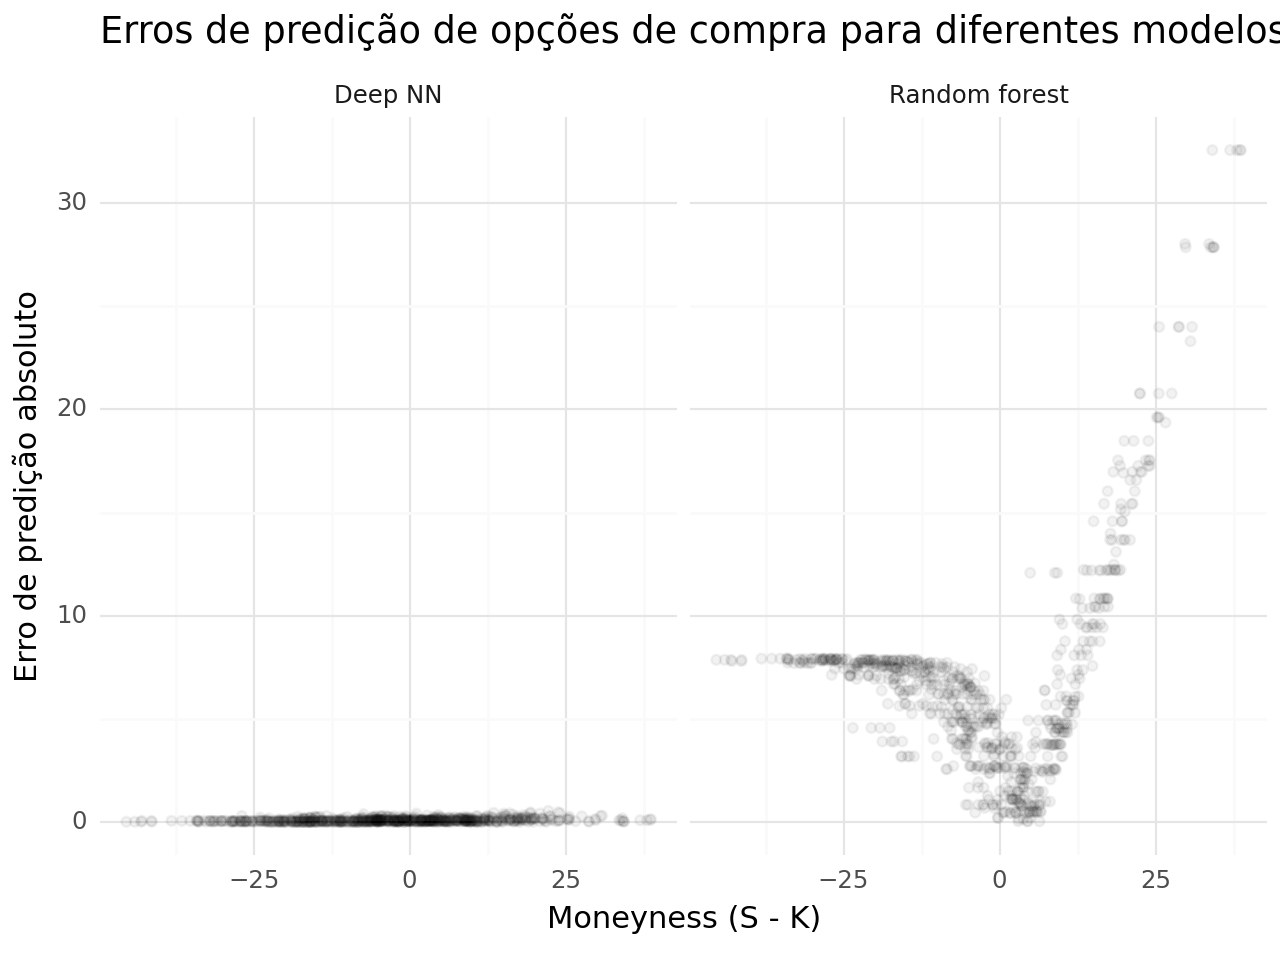

<Figure Size: (640 x 480)>

In [ ]:
# Plotagem do desempenho preditivo
predictive_performance_plot = (
  ggplot(predictive_performance,
         aes(x="moneyness", y="pricing_error")) +
  geom_point(alpha=0.05) +
  facet_wrap("Model") +
  labs(x="Moneyness (S - K)", y="Erro de predição absoluto",
       title="Erros de predição de opções de compra para diferentes modelos") +
  theme(legend_position="") +
  theme_minimal()
)

predictive_performance_plot